<a href="https://colab.research.google.com/github/LucasAfa/Projeto2-IF775/blob/main/projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import linear_model

import matplotlib as mpl




In [2]:
fifa20=pd.read_csv("https://raw.githubusercontent.com/LucasAfa/Projeto2-IF775/main/players_20.csv", header=0)
print(fifa20)

       sofifa_id                                         player_url  ...   rcb    rb
0         158023  https://sofifa.com/player/158023/lionel-messi/...  ...  52+2  63+2
1          20801  https://sofifa.com/player/20801/c-ronaldo-dos-...  ...  53+3  61+3
2         190871  https://sofifa.com/player/190871/neymar-da-sil...  ...  46+3  61+3
3         200389  https://sofifa.com/player/200389/jan-oblak/20/...  ...   NaN   NaN
4         183277  https://sofifa.com/player/183277/eden-hazard/2...  ...  49+3  61+3
...          ...                                                ...  ...   ...   ...
18273     245006  https://sofifa.com/player/245006/shuai-shao/20...  ...  46+2  45+2
18274     250995  https://sofifa.com/player/250995/mingjie-xiao/...  ...  47+2  46+2
18275     252332  https://sofifa.com/player/252332/wei-zhang/20/...  ...  49+2  47+2
18276     251110  https://sofifa.com/player/251110/haijian-wang/...  ...  49+2  48+2
18277     233449  https://sofifa.com/player/233449/ximing-pan/20.

In [3]:
fifa20 = fifa20[(fifa20.team_position != "GK")]
fifa20.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,94,94,95500000,565000,"RW, CF, ST",Left,5,4,4,Medium/Low,Messi,Yes,195800000.0,"#Dribbler, #Distance Shooter, #Crosser, #FK Sp...",RW,10.0,NaN,2004-07-01,2021.0,NaN,NaN,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,...,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89+2,89+2,89+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,92+2,87+2,87+2,87+2,92+2,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,93,93,58500000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,96500000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,...,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,92,105500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,195200000.0,"#Speedster, #Dribbler, #Playmaker , #Crosser,...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,...,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84+3,84+3,84+3,90+3,89+3,89+3,89+3,90+3,90+3,90+3,90+3,89+3,82+3,82+3,82+3,89+3,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,91,91,90000000,470000,"LW, CF",Right,4,4,4,High/Medium,Normal,Yes,184500000.0,"#Speedster, #Dribbler, #Acrobat",LW,7.0,NaN,2019-07-01,2024.0,LF,10.0,91.0,83.0,86.0,94.0,35.0,66.0,NaN,NaN,NaN,...,54,41,87,89,88,91,34,27,22,11,12,6,8,8,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,83+3,83+3,83+3,89+3,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3
5,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,28,1991-06-28,181,70,Belgium,Manchester City,91,91,90000000,370000,"CAM, CM",Right,4,5,4,High/High,Normal,Yes,166500000.0,"#Dribbler, #Playmaker , #Engine, #Distance Sh...",RCM,17.0,NaN,2015-08-30,2023.0,RCM,7.0,76.0,86.0,92.0,86.0,61.0,78.0,NaN,NaN,NaN,...,76,61,88,94,79,91,68,58,51,15,13,5,10,13,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3


In [4]:
fifa20['nationality'] = fifa20['nationality'].astype('category')
fifa20['club'] = fifa20['club'].astype('category')
fifa20['team_position'] = fifa20['team_position'].astype('category')

fifa20['team_position'] = fifa20['team_position'].cat.codes
fifa20['country_code'] = fifa20['nationality'].cat.codes
fifa20['club_code'] = fifa20['club'].cat.codes

fifa20 = fifa20._get_numeric_data()


In [5]:
fifa20 = fifa20.dropna(thresh=0.7*len(fifa20), axis=1)
fifa20.describe


<bound method NDFrame.describe of        sofifa_id  age  height_cm  ...  goalkeeping_reflexes  country_code  club_code
0         158023   32        170  ...                     8             5        224
1          20801   34        187  ...                    11           120        350
2         190871   27        175  ...                    11            18        462
4         183277   28        175  ...                     8            12        505
5         192985   28        181  ...                    13            12        400
...          ...  ...        ...  ...                   ...           ...        ...
18273     245006   22        186  ...                    14            28         79
18274     250995   22        177  ...                     9            28        574
18275     252332   19        186  ...                    14            28        317
18276     251110   18        185  ...                    13            28        573
18277     233449   26        18

In [6]:
fifa20['release_clause_eur'].fillna(fifa20['release_clause_eur'].mean(), inplace=True)


In [16]:
X, y = fifa20, fifa20['value_eur']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,train_size=0.8,random_state=9,)

print(f"Train labels:\n{y_train}")
print(f"Test labels:\n{y_test}")
print(f"Train labels:\n{X_train}")
print(f"Test labels:\n{X_test}")

Train labels:
11384      625000
13026      300000
10328      750000
1789      8500000
13140      625000
           ...   
4812      3000000
4957      2200000
5323       875000
10501      600000
564      10500000
Name: value_eur, Length: 14092, dtype: int64
Test labels:
7605      900000
369      8000000
1530     6500000
3821      850000
13986     525000
          ...   
12369     575000
1537     6500000
1488     7500000
11669     575000
7951      950000
Name: value_eur, Length: 3524, dtype: int64
Train labels:
       sofifa_id  age  height_cm  ...  goalkeeping_reflexes  country_code  club_code
11384     205145   24        183  ...                    14           127        106
13026     216134   29        175  ...                    16            40         21
10328     240891   23        172  ...                    10            57        233
1789      206594   24        180  ...                    15            45         99
13140     251341   18        177  ...                    10 

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.25,train_size=0.75,random_state=9,)


In [9]:
import pandas as pd
import numpy as np

corr = fifa20.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r' & 'BrBG' are other good diverging colormaps

R2:      0.945
MSE:     1385655358597.020


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


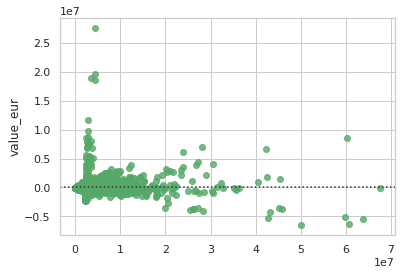

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

model = LinearRegression()

columns = ['release_clause_eur', 'wage_eur']

model.fit(X_train[columns], y_train)

predict = model.predict(X_val[columns])

mse = mean_squared_error(y_val, predict)
r2 = r2_score(y_val, predict)

print("R2:      {:.3f}".format(r2))
print("MSE:     {:.3f}".format(mse))

sns.set(style="whitegrid")
sns.residplot(predict, y_val, color="g")
#calcular mape, male

In [21]:
import optuna
import pandas as pd
from sklearn import linear_model
from sklearn import ensemble
from sklearn import datasets
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
#MLP, SVR

In [24]:
model1  = RandomForestRegressor()
columns = ['release_clause_eur', 'wage_eur']
model1.fit(X_train[columns], y_train)# Mostrando importância de cada feature
model1.feature_importances_

array([0.97294353, 0.02705647])

R2:      0.990
MSE:     260634563300.284


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



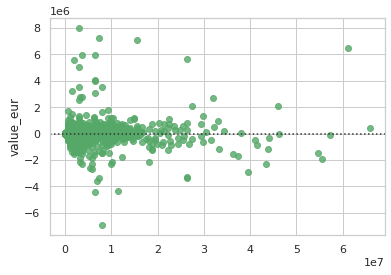

In [29]:
predict = model1.predict(X_val[columns])

mse1 = mean_squared_error(y_val, predict)
r21 = r2_score(y_val, predict)

print("R2:      {:.3f}".format(r21))
print("MSE:     {:.3f}".format(mse1))

sns.set(style="whitegrid")
sns.residplot(predict, y_val, color="g")

R2:      -0.116
MSE:     28202051293830.766


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



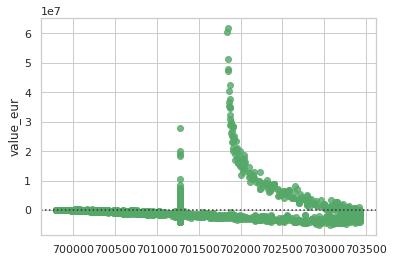

In [35]:
from sklearn.svm import SVR

model2  = SVR()
columns = ['release_clause_eur']
model2.fit(X_train[columns], y_train)

predict = model2.predict(X_val[columns])

mse2 = mean_squared_error(y_val, predict)
r22 = r2_score(y_val, predict)

print("R2:      {:.3f}".format(r22))
print("MSE:     {:.3f}".format(mse2))

sns.set(style="whitegrid")
sns.residplot(predict, y_val, color="g")

R2:      0.945
MSE:     1389947196983.531


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



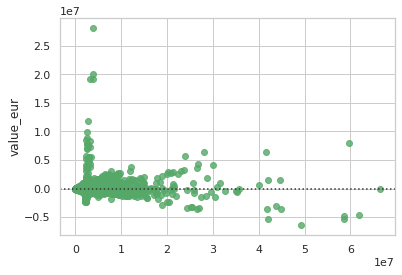

In [36]:
from sklearn.neural_network import MLPRegressor

model3  = MLPRegressor()
columns = ['release_clause_eur', 'wage_eur']
model3.fit(X_train[columns], y_train)

predict = model3.predict(X_val[columns])

mse3 = mean_squared_error(y_val, predict)
r23 = r2_score(y_val, predict)

print("R2:      {:.3f}".format(r23))
print("MSE:     {:.3f}".format(mse3))

sns.set(style="whitegrid")
sns.residplot(predict, y_val, color="g")